This notebook is to demonstrate the python solution on getting total precipitation of ECWMF forcast.

Reference: https://www.heywhale.com/mw/project/65d5e3cc1bf0d23bbb4bc435?shareby=620dbd752e0e510017d2f245

In [ ]:
#@title Install and import all packages
!pip install ecmwf-opendata
!pip install pygrib
!pip install xarray
!pip install matplotlib
!pip install cartopy
!pip install netCDF4

from ecmwf.opendata import Client
import pygrib
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pygrib as pg
import numpy as np
import netCDF4 as nc
import time
import datetime
import requests
import glob
import os

  Preparing metadata (setup.py) ... done
  Created wheel for multiurl: filename=multiurl-0.3.3-py3-none-any.whl size=21230 sha256=ae78e06fb17a8b33a442eed877c00d07734ff012a00f1810426da8ccdc153c42
  Stored in directory: /root/.cache/pip/wheels/5a/9e/1e/e307bfc2dddf5adbd8c17f157e42b5ed54a0598a24e54fd202
Successfully built multiurl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.0 MB/s eta 0:00:00


In [ ]:
#@title Get gust data
def ECWMFGustData(productDate, productTime, forcastPoint):
  client = Client()

  client.retrieve(
      date=productDate,
      time=productTime,
      step=forcastPoint,
      stream='oper',
      type="fc",
      param="10fg",
      target="data.grib2",
  )

In [ ]:
#@title grib2 to nc
def grib2ToNc(filename):
  grb = pg.open(filename)
  ncname = filename.replace('.grib2','.nc')
  da = nc.Dataset(ncname,'w',format='NETCDF4')

  g = grb[1]
  lat,lon = g.latlons()
  da.createDimension('lat',np.size(lat,0))
  da.createDimension('lon',np.size(lat,1))

  # add lat and lon variables
  da.createVariable('lat','f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
  da.createVariable('lon','f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
  da.variables['lat'][:]=lat
  da.variables['lon'][:]=lon

  for g in grb:

      # extract data and attribute
      varname = g.name
      data = g.values
      unit = g.units
      level = g.level

      # write into nc file
      if varname=='unknown':
          continue
      if level!=0:
          varname = varname + ' ' + str(level) + 'hPa'
      # print(varname)
      d = da.createVariable(varname,'f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
      d.units = unit
      da.variables[varname][:] = data

  da.close()
  grb.close()
  ncname
  return ncname

In [ ]:
#@title grib2 to opendataset

def grib2ToOpendataset():
  # ds is the "gust" at the timePoint
  ds = xr.open_dataset(grib2ToNc("data.grib2"))

  data = pygrib.open("data.grib2")
  g = data[1]
  lat, lon = g.latlons()

  # Limit the area of data we needed, here we got the data with in the area bounded by (26N, 108E), (26N, 120E), (18N, 120E) and (18N, 108E)
  ds = ds.where(lat >= 18).where(lat <= 26).where(lon >= 108).where(lon <= 120)

  return ds

In [ ]:
#@title plot to dataset
def plot_dataset(dataset : xr.Dataset):
    projection = ccrs.Mercator()
    crs = ccrs.PlateCarree()

    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=False)

    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("10m"), lw=0.75)
    ax.add_feature(cf.BORDERS.with_scale("10m"), lw=0.3)

    lon_min = 108
    lon_max = 120
    lat_min = 18
    lat_max = 26

    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.75, "pad" : .05, 'aspect':8, 'label':''}

    colors = ["white", "white", "white", "grey", "green", "blue", "red", "#ff99cc", "#cc66ff"]

    dataset.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=10, vmin=0, vmax=18, colors=colors)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    #plt.title(f"Temperature anomaly over Europe in")
    plt.show()

In [ ]:
#@title GustInformation function
def GustInformation(forcastDate, forcastTime, timePoint):

  ECWMFGustData(forcastDate, forcastTime, timePoint)

  Gust = grib2ToOpendataset()

  # convert the wind gust to Beaufort scale
  x = np.fabs(Gust["Maximum 10 metre wind gust since previous post-processing 10hPa"]) / 0.836
  x = np.power(x, 2/3)
  plot_dataset(x)

20250308000000-24h-oper-fc.grib2:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

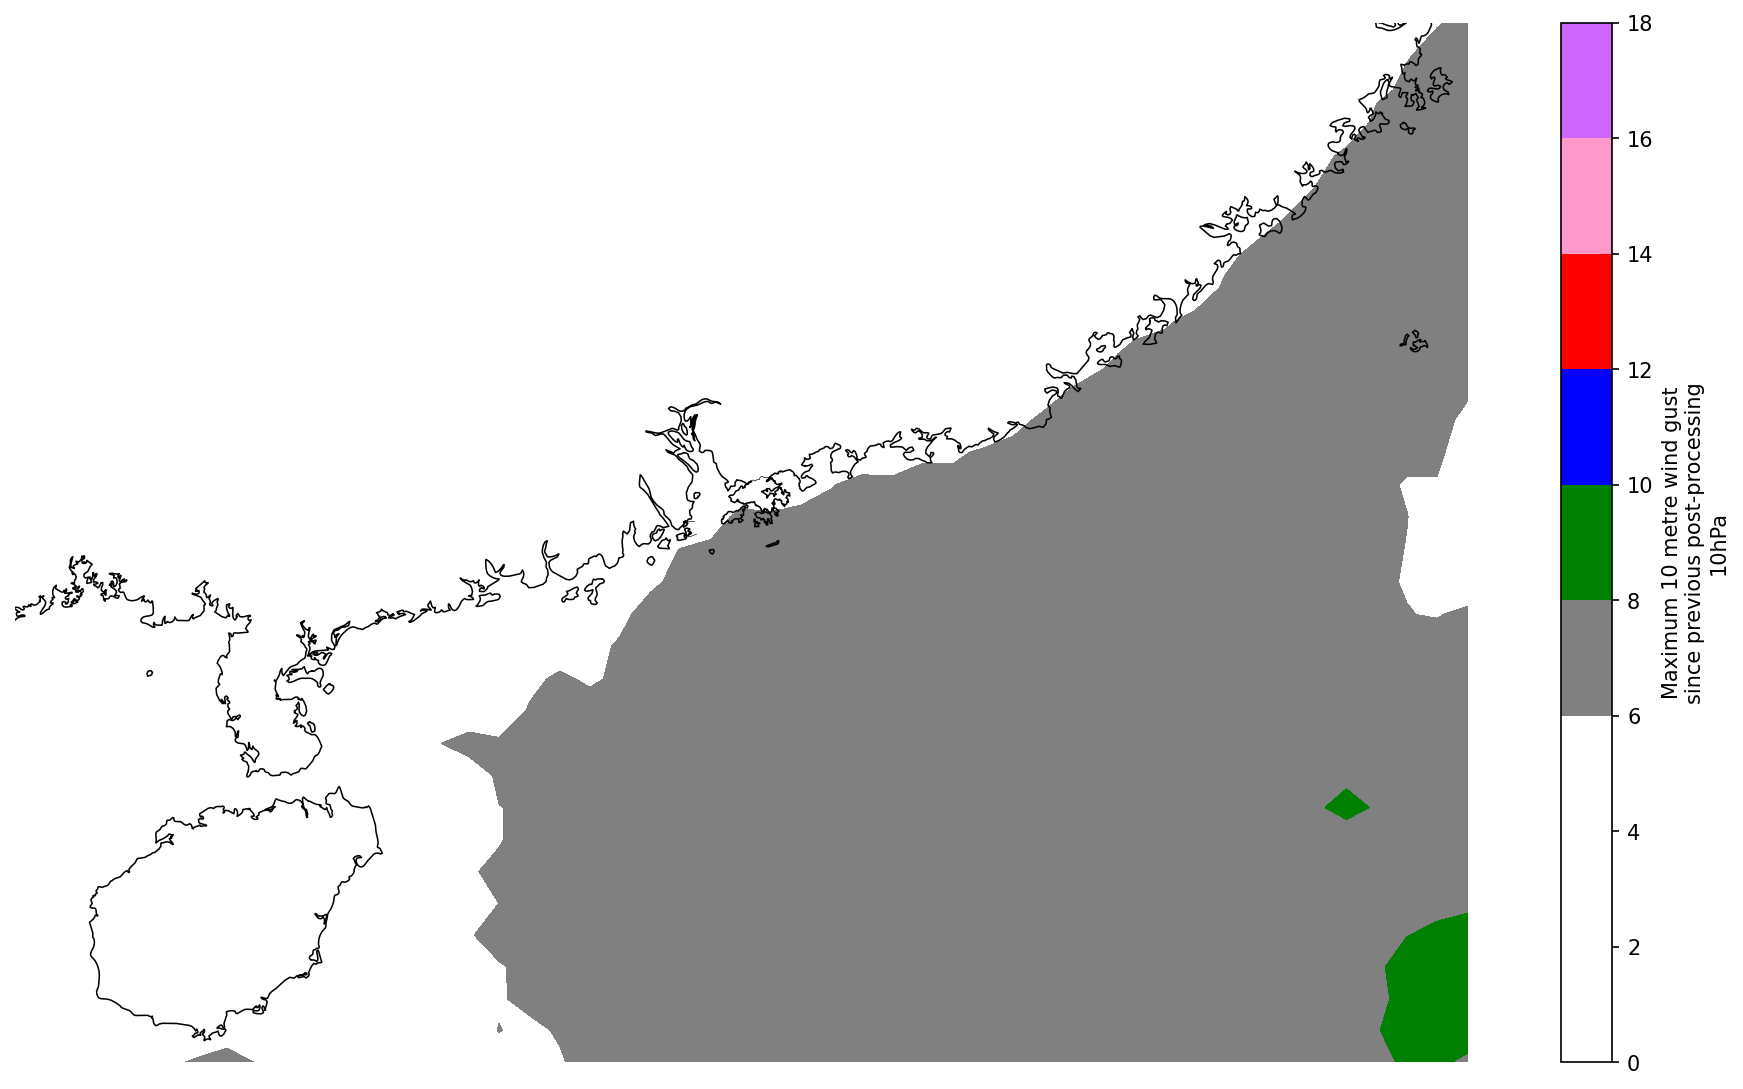

In [ ]:
#@title Main function

# Variable: Date of forcast start
forcastDate = "2025-03-08"

# Variable: Time of forcast start, only 0, 6, 12 and 18 available, corresponding to 00UTC, 06UTC, 12UTC and 18UTC
forcastTime = 0

# Variable: starting forcast step point in hours, 0 to 360 (for 00UTC and 12UTC) or 0 to 144 (for 06UTC and 18UTC)
timePoint = 24

# return image that the total precipitation within the period from starting forcast step point
# unit: Beaufort scale
GustInformation(forcastDate, forcastTime, timePoint)